# Preprocessing

In [11]:
import pandas as pd

import sys
sys.path.append('../..')


from src.support_encoding import *
from src.support_pre import *
from src.support_plots import * 

Vamos a eliminar algunas columnas que hemos visto que pueden no ser representativas: municipality al tener muchas categorías, y numPhotos porque no tenía correlación con la VR. Además nos deshacemos de la provincia de Segovia al tener solo 1 casa, por lo que nuestro modelo no podría predecir bien ninguna vivienda de esa provincia.

In [ ]:
df = pd.read_csv("../../datos/clean_data.csv", index_col = 0)
df.drop(columns=["municipality", "numPhotos"], inplace=True)
df.drop(index = df[df["province"] == "Segovia"].index, inplace=True)
df.reset_index(inplace=True, drop=True)
df.head()

,price,propertyType,size,exterior,rooms,bathrooms,province,showAddress,distance,hasVideo,status,newDevelopment,hasPlan,has3DTour,has360,floor,hasLift,hasParkingSpace,isParkingSpaceIncludedInPrice
0,550.0,chalet,371.0,False,6,3,Toledo,False,40116,False,good,False,False,False,False,unknown,unknown,unknown,unknown
1,750.0,flat,60.0,True,1,1,Madrid,True,7037,False,good,False,False,False,False,3,True,unknown,unknown
2,750.0,flat,70.0,True,2,1,Madrid,False,16145,True,good,False,True,False,False,bj,False,unknown,unknown
3,400.0,penthouse,67.0,True,2,2,Madrid,False,55041,False,good,False,False,False,True,2,False,unknown,unknown
4,450.0,flat,89.0,False,2,1,Toledo,False,47186,False,good,False,False,False,False,2,True,True,True


Convertimos las columnas categóricas a su formato correcto.

In [13]:
df[df.select_dtypes("bool").columns] = df.select_dtypes("bool").astype("str")

In [14]:
df[["rooms", "bathrooms"]] = df[["rooms", "bathrooms"]].astype("str")

In [15]:
num_cols = df.select_dtypes("number").columns
cat_cols = df.select_dtypes("O").columns

df[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   price     434 non-null    float64
 1   size      434 non-null    float64
 2   distance  434 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 10.3 KB


In [16]:
df[cat_cols].head()

,propertyType,exterior,rooms,bathrooms,province,showAddress,hasVideo,status,newDevelopment,hasPlan,has3DTour,has360,floor,hasLift,hasParkingSpace,isParkingSpaceIncludedInPrice
0,chalet,False,6,3,Toledo,False,False,good,False,False,False,False,unknown,unknown,unknown,unknown
1,flat,True,1,1,Madrid,True,False,good,False,False,False,False,3,True,unknown,unknown
2,flat,True,2,1,Madrid,False,True,good,False,True,False,False,bj,False,unknown,unknown
3,penthouse,True,2,2,Madrid,False,False,good,False,False,False,True,2,False,unknown,unknown
4,flat,False,2,1,Toledo,False,False,good,False,False,False,False,2,True,True,True


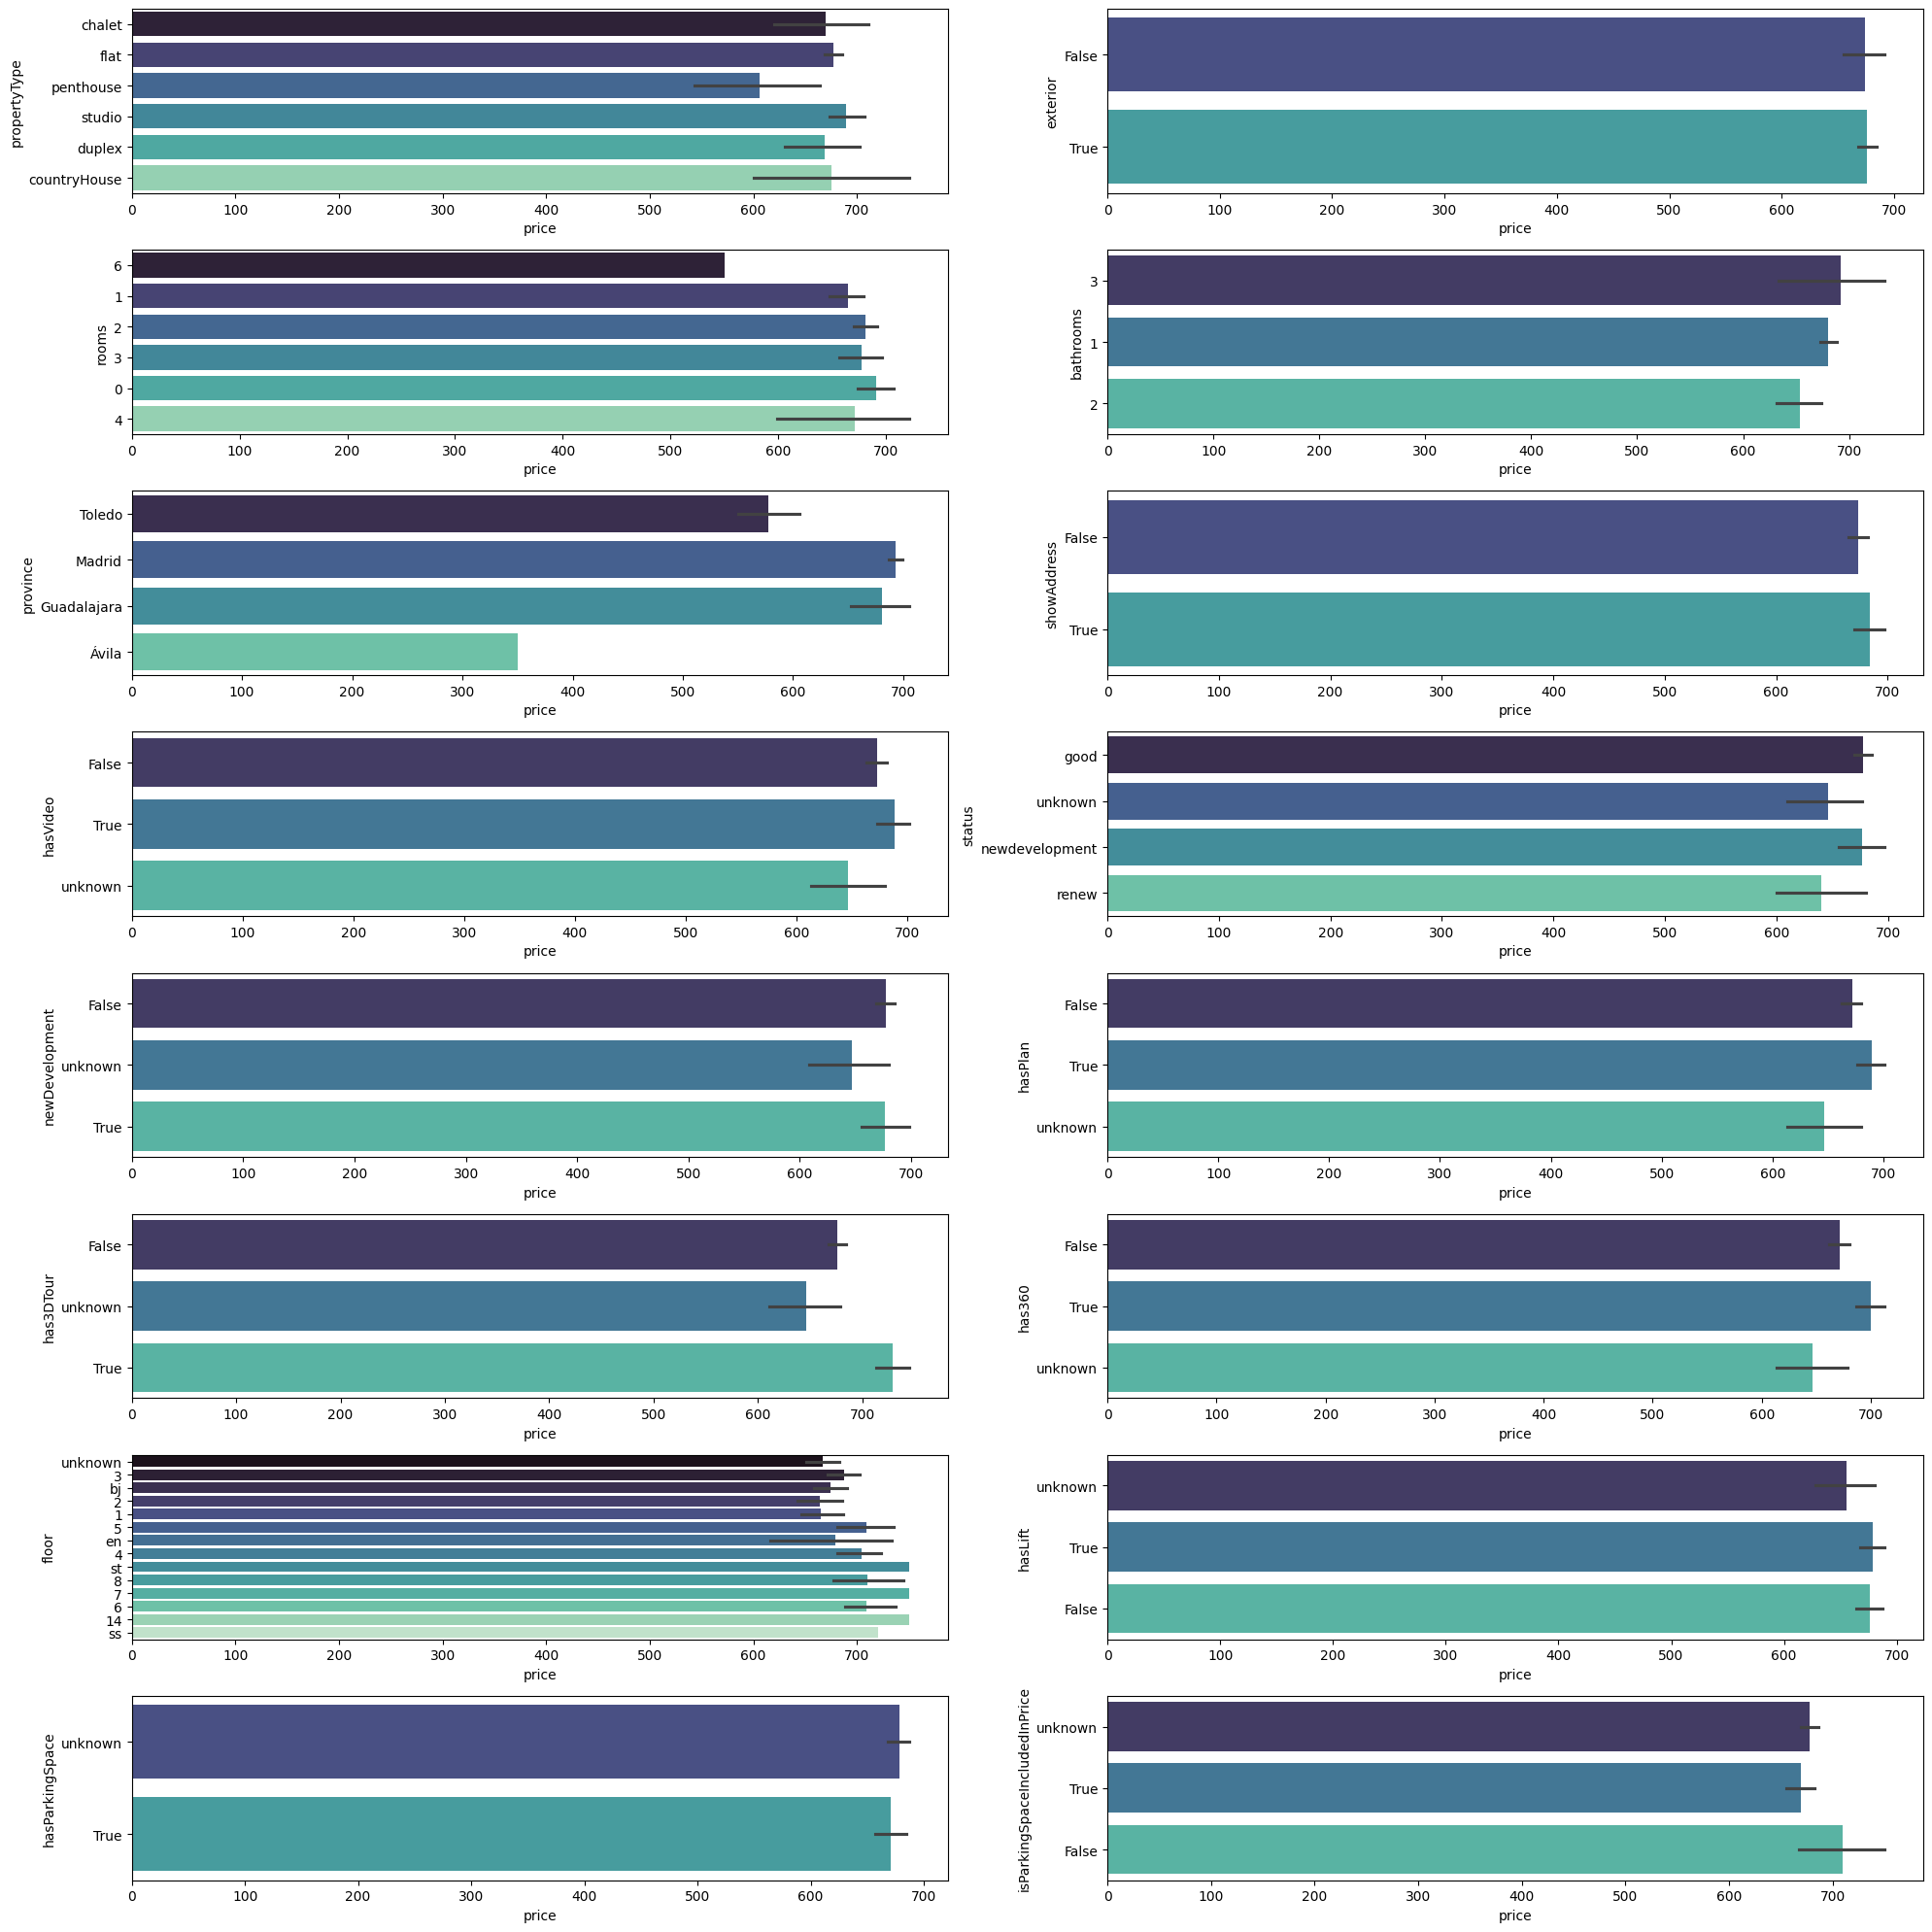

In [17]:
plot_cats(data = df, columns = cat_cols, rv = "price", plot_size=(20,20))

Vamos a comprobar qué categorías presentan diferencias significativas:

In [18]:
# asunciones = Asunciones(dataframe=df, columna_numerica="price")


# for categoria in cat_cols:   

#     print(f"Estamos analizando la variable {categoria.upper()}")
    
#     asunciones.identificar_normalidad(metodo = "shapiro") 

#     # comprobamos la homogeneidad de varianzas
#     asunciones.identificar_homogeneidad(columna_categorica = categoria)

#     # instanciamos la clase para evaluar si hay diferencias entre los distintos grupos de las variables categóricas
#     test = TestEstadisticos(df, "price", categoria)
#     test.run_all_tests()
#     print("\n###########################\n")

Vemos que ninguna es normal y las únicas que contienen categorías con diferencias son las siguientes.

In [19]:
cat_cols_ordinal = ["has360", "province", "propertyType", "bathrooms"]
cat_cols_nominal = cat_cols.drop(cat_cols_ordinal)

Separamos las categóricas en ordinales y nominales para su encoding.

#### Encoding

Usamos onehot para las nominales.

In [20]:
onehot_df, oh_encoder = encode_onehot(df, cat_cols_nominal)

Target para las ordinales. En ambos casos guardamos los objetos en caso de que luego queramos introducir datos nuevos.

In [21]:
df_w_target, target_encoder = encode_target(df, cat_cols_ordinal, "price")

In [ ]:
df_encoded = pd.concat([df[num_cols], df_w_target, onehot_df], axis = 1)
df_encoded.head()

,price,propertyType,size,bathrooms,province,distance,has360,exterior_False,exterior_True,rooms_0,...,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown,hasParkingSpace_True,hasParkingSpace_unknown,isParkingSpaceIncludedInPrice_False,isParkingSpaceIncludedInPrice_True,isParkingSpaceIncludedInPrice_unknown
0,550.0,674.434141,371.0,679.027033,579.743213,40116,671.176292,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,750.0,677.423977,60.0,680.495726,692.932011,7037,671.176292,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,750.0,677.423977,70.0,680.495726,692.932011,16145,671.176292,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,400.0,651.137922,67.0,653.853023,692.932011,55041,699.901503,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,450.0,677.423977,89.0,680.495726,579.743213,47186,671.176292,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Feature Scaling

Ahora con las categóricas convertidas a numéricas podemos hacer la estandarización.

In [ ]:
df_scaled_cols, scaler = scale_data(data = df_encoded, columns = df_encoded.columns.drop(onehot_df.columns).drop("price"))
df_scaled = pd.concat([df_encoded["price"], df_scaled_cols, onehot_df], axis = 1)

In [30]:
df_scaled.head()

,price,propertyType,size,bathrooms,province,distance,has360,exterior_False,exterior_True,rooms_0,...,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown,hasParkingSpace_True,hasParkingSpace_unknown,isParkingSpaceIncludedInPrice_False,isParkingSpaceIncludedInPrice_True,isParkingSpaceIncludedInPrice_unknown
0,550.0,-2.989836,9.088235,-1.468693,-113.188799,0.760368,0.000000,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,750.0,0.000000,-0.058824,0.000000,0.000000,-0.467498,0.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
2,750.0,0.000000,0.235294,0.000000,0.000000,-0.129416,0.000000,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,400.0,-26.286055,0.147059,-26.642703,0.000000,1.314372,28.725211,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,450.0,0.000000,0.794118,0.000000,-113.188799,1.022800,0.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Outliers

Vemos que tenemos pocos outliers, por lo que podríamos usar cualquiera de los dos métodos para gestionarlos (IFo o LOF), ya que hay tanto puntuales como agrupados.

In [21]:
df_outliers, outlier_finder = find_outliers(data = df_encoded, columns=df_encoded.columns, method = "ifo", threshold=60)
df_outliers

100%|██████████| 25/25 [00:15<00:00,  1.63it/s]


,price,propertyType,size,bathrooms,province,distance,has360,exterior_False,exterior_True,rooms_0,...,floor_st,floor_unknown,hasLift_False,hasLift_True,hasLift_unknown,hasParkingSpace_True,hasParkingSpace_unknown,isParkingSpaceIncludedInPrice_False,isParkingSpaceIncludedInPrice_True,isParkingSpaceIncludedInPrice_unknown
7,684.0,688.838807,45.0,680.495726,692.932011,10656,662.595666,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
36,750.0,677.423977,95.0,653.853023,579.743213,34444,662.595666,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
65,700.0,677.423977,50.0,653.853023,692.932011,32052,662.595666,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
66,750.0,672.352667,35.0,680.495726,692.932011,4047,662.595666,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
124,624.0,677.423977,45.0,680.495726,692.932011,24077,671.176292,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
125,633.0,677.423977,45.0,680.495726,692.932011,24077,671.176292,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
136,550.0,677.423977,106.0,680.495726,579.743213,53694,662.595666,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
148,630.0,677.423977,54.0,653.853023,692.932011,32432,662.595666,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
157,550.0,651.137922,80.0,680.495726,579.743213,33038,671.176292,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
168,700.0,688.838807,23.0,680.495726,692.932011,1271,662.595666,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Los volvemos nulos para imputarlos

In [22]:
df_encoded.loc[df_outliers.index, num_cols.drop('price')] = np.nan

In [23]:
df_out_imputed, outlier_imputer = impute_nulls(data=df_encoded)

[IterativeImputer] Completing matrix with shape (434, 55)
[IterativeImputer] Ending imputation round 1/10, elapsed time 7.02
[IterativeImputer] Change: 30137.34430656934, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 2/10, elapsed time 13.18
[IterativeImputer] Change: 3760.7200000000025, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 3/10, elapsed time 19.24
[IterativeImputer] Change: 4092.3949999999995, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 4/10, elapsed time 25.88
[IterativeImputer] Change: 4517.645, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 5/10, elapsed time 45.48
[IterativeImputer] Change: 2150.4000000000055, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 6/10, elapsed time 76.81
[IterativeImputer] Change: 2824.9399999999987, scaled tolerance: 59.351 
[IterativeImputer] Ending imputation round 7/10, elapsed time 98.52
[IterativeImputer] Change: 4177.21500000

Vemos que la imputación ha sido exitosa, sin haber cambiado mucho las métricas.

In [24]:
display(df_encoded[num_cols].describe())
df_out_imputed[num_cols].describe()

,price,size,distance
count,434.000000,411.000000,411.000000
mean,675.910138,67.350365,21347.715328
std,81.339387,35.015616,16415.103255
min,340.000000,20.000000,183.000000
25%,650.000000,47.000000,6902.500000
50%,700.000000,62.000000,18905.000000
75%,740.000000,80.000000,33114.000000
max,750.000000,371.000000,59351.000000


,price,size,distance
count,434.000000,434.000000,434.000000
mean,675.910138,70.146659,21970.734948
std,81.339387,37.646212,16361.402102
min,340.000000,20.000000,183.000000
25%,650.000000,48.000000,7092.000000
50%,700.000000,62.500000,20294.000000
75%,740.000000,84.000000,34854.750000
max,750.000000,371.000000,59351.000000


Guardamos en un csv.

In [27]:
df_out_imputed.to_csv("../../datos/Iteration1/prepped_data.csv")